In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow_model_optimization as tfmot
import tempfile
from PIL import Image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from keras.applications.mobilenet_v2 import MobileNetV2
import pandas as pd
import cv2

#from tqdm import tqdm
# tqdm doesn't work well in colab.
# This is the solution:
# https://stackoverflow.com/questions/41707229/tqdm-printing-to-newline
import tqdm.notebook as tq
#for i in tq.tqdm(...):

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install tensorflow_model_optimization
!pip install keras-efficientnets
!pip install keras.utils
!pip install keras_applications

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 238 kB 24.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2656 sha256=d2ef4e9447e122966983adc0f6842bd7e7779b991268fb960aa6dc1d33efb5a1
  Stored in directory: /root/.cache/pip/wheels/d0/dd/3b/493952a5240d486a83805d65360dedadbadeae71d25e2c877f
Successfully built keras.utils
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 7.5 MB/s 


In [ ]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title
os.listdir('/content/drive/MyDrive/cifar-100-python')

['train',
 'test',
 'file.txt~',
 'meta',
 '.~lock.train#',
 'People_Binary_Classification',
 '.ipynb_checkpoints',
 'not_people.csv',
 'people.csv']

In [ ]:
#@title
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
#@title
path = '/content/drive/MyDrive/cifar-100-python/train'

train_dict = unpickle(path)

train_dict.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

In [ ]:
#@title
path = '/content/drive/MyDrive/cifar-100-python/meta'

names_dict = unpickle(path)

names_dict.keys()

dict_keys([b'fine_label_names', b'coarse_label_names'])

In [ ]:
#@title
fine_labels_list = train_dict[b'fine_labels']
coarse_labels_list = train_dict[b'coarse_labels']

fine_label_names_list = names_dict[b'fine_label_names']
coarse_label_names_list = names_dict[b'coarse_label_names']

print(len(fine_labels_list))
print(len(coarse_labels_list))
print(len(fine_label_names_list))
print(len(coarse_label_names_list))

50000
50000
100
20


In [ ]:
#@title
# Create the df_train dataframe
df_train = pd.DataFrame(fine_labels_list, columns=['fine_labels'])

# Create new columns
df_train['coarse_labels'] = coarse_labels_list
df_train['image_num'] = df_train.index + 100000

# Create the image_id column
def create_imageid(row):
    
    image_id = str(row['fine_labels']) + '_' + str(row['coarse_labels']) + '_' + str(row['image_num']) +'.jpg'
    
    return image_id

df_train['image_id'] = df_train.apply(create_imageid, axis=1)


# Create the fine and coarse label names columns

def create_finelabelname(x):
    
    # this returns bytes: b'apple'
    name = fine_label_names_list[x]
    
    # convert bytes to string: 'apple'
    name = name.decode("utf-8") 
    
    return name


def create_coarselabelname(x):
    
    # this returns bytes: b'apple'
    name = coarse_label_names_list[x]
    
    # convert bytes to string: 'apple'
    name = name.decode("utf-8") 
    
    return name


df_train['fine_label_names'] = df_train['fine_labels'].apply(create_finelabelname)

df_train['coarse_label_names'] = df_train['coarse_labels'].apply(create_coarselabelname)


# Remove unnecessary columns
df_train = df_train.drop('image_num', axis=1)

# Reorder the columns
cols = ['image_id', 'fine_label_names', 'fine_labels', 'coarse_label_names', 'coarse_labels']
df_train = df_train[cols]

df_train.head()

,image_id,fine_label_names,fine_labels,coarse_label_names,coarse_labels
0,19_11_100000.jpg,cattle,19,large_omnivores_and_herbivores,11
1,29_15_100001.jpg,dinosaur,29,reptiles,15
2,0_4_100002.jpg,apple,0,fruit_and_vegetables,4
3,11_14_100003.jpg,boy,11,people,14
4,1_1_100004.jpg,aquarium_fish,1,fish,1


In [ ]:
#@title
path = '/content/drive/MyDrive/cifar-100-python/test'

test_dict = unpickle(path)

test_dict.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

In [ ]:
#@title
fine_labels_list = test_dict[b'fine_labels']
coarse_labels_list = test_dict[b'coarse_labels']

fine_label_names_list = names_dict[b'fine_label_names']
coarse_label_names_list = names_dict[b'coarse_label_names']

print(len(fine_labels_list))
print(len(coarse_labels_list))
print(len(fine_label_names_list))
print(len(coarse_label_names_list))

10000
10000
100
20


In [ ]:
#@title
# Create the df_test dataframe
df_test = pd.DataFrame(fine_labels_list, columns=['fine_labels'])

# Create new columns
df_test['coarse_labels'] = coarse_labels_list
df_test['image_num'] = df_test.index + 200000

# Create the image_id column
def create_imageid(row):
    
    image_id = str(row['fine_labels']) + '_' + str(row['coarse_labels']) + '_' + str(row['image_num']) +'.jpg'
    
    return image_id

df_test['image_id'] = df_test.apply(create_imageid, axis=1)


# Create the fine and coarse label names columns

def create_finelabelname(x):
    
    # this returns bytes: b'apple'
    name = fine_label_names_list[x]
    
    # convert bytes to string: 'apple'
    name = name.decode("utf-8") 
    
    return name


def create_coarselabelname(x):
    
    # this returns bytes: b'apple'
    name = coarse_label_names_list[x]
    
    # convert bytes to string: 'apple'
    name = name.decode("utf-8") 
    
    return name


df_test['fine_label_names'] = df_test['fine_labels'].apply(create_finelabelname)

df_test['coarse_label_names'] = df_test['coarse_labels'].apply(create_coarselabelname)


# Remove unnecessary columns
df_test = df_test.drop('image_num', axis=1)

# Reorder the columns
cols = ['image_id', 'fine_label_names', 'fine_labels', 'coarse_label_names', 'coarse_labels']
df_test = df_test[cols]

df_test.head()

,image_id,fine_label_names,fine_labels,coarse_label_names,coarse_labels
0,49_10_200000.jpg,mountain,49,large_natural_outdoor_scenes,10
1,33_10_200001.jpg,forest,33,large_natural_outdoor_scenes,10
2,72_0_200002.jpg,seal,72,aquatic_mammals,0
3,51_4_200003.jpg,mushroom,51,fruit_and_vegetables,4
4,71_10_200004.jpg,sea,71,large_natural_outdoor_scenes,10


In [ ]:
#@title

df_train.to_csv('train.csv', index=False)
df_test.to_csv('test.csv', index=False)

In [ ]:
#@title

train_csv = pd.read_csv('/content/train.csv')
test_csv = pd.read_csv('/content/test.csv')

train_data = pd.DataFrame(train_csv)
test_data =  pd.DataFrame(test_csv)

#CLEAR

In [ ]:
#@title

path_train = '/content/drive/MyDrive/cifar-100-python/train'

train_dict = unpickle(path_train)
train_matrix = train_dict[b'data']

path_test = '/content/drive/MyDrive/cifar-100-python/test'

test_dict = unpickle(path_test)
test_matrix = test_dict[b'data']

In [ ]:
#@title

print(test_matrix.shape)
train_data.head()

(10000, 3072)


,image_id,fine_label_names,fine_labels,coarse_label_names,coarse_labels
0,19_11_100000.jpg,cattle,19,large_omnivores_and_herbivores,11
1,29_15_100001.jpg,dinosaur,29,reptiles,15
2,0_4_100002.jpg,apple,0,fruit_and_vegetables,4
3,11_14_100003.jpg,boy,11,people,14
4,1_1_100004.jpg,aquarium_fish,1,fish,1


In [ ]:
# Create people directory
if os.path.isdir('people_images') == True:
  dir = '/content/people_images'
  for f in os.listdir(dir):
      os.remove(os.path.join(dir, f))

if os.path.isdir('people_images') == False:
    train_images = 'people_images'
    os.mkdir(train_images)


# Create not_people directory
if os.path.isdir('not_people_images') == True:
  dir = '/content/not_people_images'
  for f in os.listdir(dir):
      os.remove(os.path.join(dir, f))

else:
    train_images = 'not_people_images'
    os.mkdir(train_images)

In [ ]:
#@title

#Combined dataframe of both test and train
combined_data = train_data.append(test_data)
combined_matrix = np.append(train_matrix,test_matrix)

In [ ]:
#@title

random = combined_data[(combined_data['fine_labels']==0)].sample(31,replace=False)        # Initialize random dataframe
# select 31 random images from each class(fine label)
for i in range(1,100):
  label_index = combined_data[(combined_data['fine_labels']==i)].sample(31,replace=False)
  random = random.append(label_index)

In [ ]:
#@title

# People dataframe from combined
people_data = combined_data[(combined_data['coarse_label_names']=='people')]

# Randomize people dataframe
people = people_data.sample(frac=1)
people.head()

,image_id,fine_label_names,fine_labels,coarse_label_names,coarse_labels
34642,35_14_134642.jpg,girl,35,people,14
3821,2_14_103821.jpg,baby,2,people,14
17242,11_14_117242.jpg,boy,11,people,14
25607,46_14_125607.jpg,man,46,people,14
39213,11_14_139213.jpg,boy,11,people,14


In [ ]:
#@title

# Remove all the people elements 
not_people = random[random.coarse_label_names != 'people']

# add 55 random elements from not people to make 3000 images (equal to people)
not_people = not_people.append(not_people.sample(n=55))

#Randomize not_people
not_people = not_people.sample(frac=1)

#Convert and store not_people dataframe to csv
# not_people.to_csv('not_people.csv')
print(len(not_people))
not_people.head()

3000


,image_id,fine_label_names,fine_labels,coarse_label_names,coarse_labels
22880,72_0_122880.jpg,seal,72,aquatic_mammals,0
2637,97_8_102637.jpg,wolf,97,large_carnivores,8
6717,71_10_206717.jpg,sea,71,large_natural_outdoor_scenes,10
22510,57_4_122510.jpg,pear,57,fruit_and_vegetables,4
16605,47_17_116605.jpg,maple_tree,47,trees,17


In [ ]:
#@title

count = 0
print(len(people))

3000


In [ ]:
#@title

# Prepare train images
for i in range(0, train_matrix.shape[0]):
    if(train_data.loc[i,'image_id'] in people.values):
      
      # Get the image_id from the df_train dataframe
      image_id = train_data.loc[i, 'image_id']


      # Select an image
      row = train_matrix[i]

      # Extract each channel
      ch0 = row[0:1024] 
      ch1 = row[1024:2048]
      ch2 = row[2048:]

      # Reshape to 32x32
      ch0 = np.reshape(ch0, (32,32)) # red
      ch1 = np.reshape(ch1, (32,32)) # green
      ch2 = np.reshape(ch2, (32,32)) # blue

      # Stack the matrices along the channel axis
      image = np.dstack((ch0, ch1, ch2))

      
      # Save the image in the folder
      # that we created.
      fname = image_id
      dst = os.path.join('people_images', fname)
      
      # If cv2.COLOR_RGB2BGR is not used then the saved images appear blue.
      cv2.imwrite(dst, image)
      count = count + 1

# Not-People
    if(train_data.loc[i,'image_id'] in not_people.values):
      # Get the image_id from the df_train dataframe
      image_id = train_data.loc[i, 'image_id']


      # Select an image
      row = train_matrix[i]

      # Extract each channel
      ch0 = row[0:1024] 
      ch1 = row[1024:2048]
      ch2 = row[2048:]

      # Reshape to 32x32
      ch0 = np.reshape(ch0, (32,32)) # red
      ch1 = np.reshape(ch1, (32,32)) # green
      ch2 = np.reshape(ch2, (32,32)) # blue

      # Stack the matrices along the channel axis
      image = np.dstack((ch0, ch1, ch2))

      
      # Save the image in the folder
      # that we created.
      fname = image_id
      dst = os.path.join('not_people_images', fname)
      
      # If cv2.COLOR_RGB2BGR is not used then the saved images appear blue.
      cv2.imwrite(dst, image)
      count = count + 1

In [ ]:
#@title

# Prepare test images
for i in range(0, test_matrix.shape[0]):
    if(test_data.loc[i,'image_id'] in people.values):
      
      # Get the image_id from the df_train dataframe
      image_id = test_data.loc[i, 'image_id']


      # Select an image
      row = test_matrix[i]

      # Extract each channel
      ch0 = row[0:1024] 
      ch1 = row[1024:2048]
      ch2 = row[2048:]

      # Reshape to 32x32
      ch0 = np.reshape(ch0, (32,32)) # red
      ch1 = np.reshape(ch1, (32,32)) # green
      ch2 = np.reshape(ch2, (32,32)) # blue

      # Stack the matrices along the channel axis
      image = np.dstack((ch0, ch1, ch2))

      
      # Save the image in the folder
      # that we created.
      fname = image_id
      dst = os.path.join('people_images', fname)
      
      # If cv2.COLOR_RGB2BGR is not used then the saved images appear blue.
      cv2.imwrite(dst, image)
      count = count + 1

# Not-People
    if(test_data.loc[i,'image_id'] in not_people.values):
      # Get the image_id from the df_train dataframe
      image_id = test_data.loc[i, 'image_id']


      # Select an image
      row = test_matrix[i]

      # Extract each channel
      ch0 = row[0:1024] 
      ch1 = row[1024:2048]
      ch2 = row[2048:]

      # Reshape to 32x32
      ch0 = np.reshape(ch0, (32,32)) # red
      ch1 = np.reshape(ch1, (32,32)) # green
      ch2 = np.reshape(ch2, (32,32)) # blue

      # Stack the matrices along the channel axis
      image = np.dstack((ch0, ch1, ch2))

      
      # Save the image in the folder
      # that we created.
      fname = image_id
      dst = os.path.join('not_people_images', fname)
      
      # If cv2.COLOR_RGB2BGR is not used then the saved images appear blue.
      cv2.imwrite(dst, image)
      count = count + 1

In [ ]:
os.mkdir('dataset')
shutil.move('/content/not_people_images','dataset/')
shutil.move('/content/people_images','dataset/')

'dataset/people_images'

In [ ]:
#@title
# Convert and store people dataframe to csv
people.to_csv('people.csv')

In [ ]:
#@title

#!zip -r /content/people.zip /content/people_images
#from google.colab import files
#files.download("/content/people.zip")

#!zip -r /content/not_people.zip /content/not_people_images
#from google.colab import files
#files.download("/content/not_people.zip")

In [ ]:
#@title

count

5945

In [ ]:
# IMPORT DATASET
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
test_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 5945 files belonging to 2 classes.
Using 4756 files for training.
Found 5945 files belonging to 2 classes.
Using 1189 files for validation.


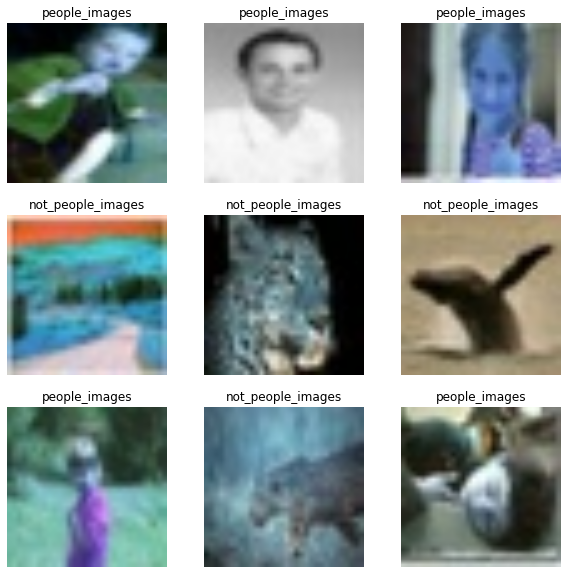

In [ ]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))
    ### END CODE HERE
    
    return data_augmentation

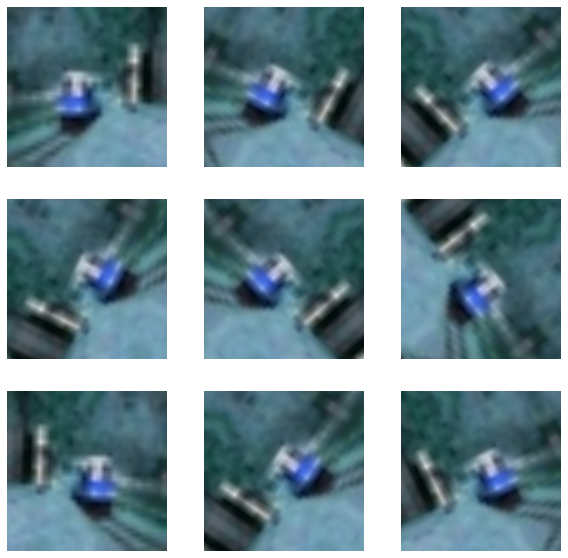

In [ ]:
data_augmentation = data_augmenter()
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
IMG_SIZE = (224,224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(include_top=False,weights='imagenet')
base_model.summary()
type(base_model)


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_15[0][0]']               
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                            

keras.engine.functional.Functional

In [ ]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 32
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = 5945
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
    initial_sparsity=0.3,
    final_sparsity=0.9,
    begin_step=0,
    end_step=end_step,
    power=3,
    frequency=100
)}

model_for_pruning = prune_low_magnitude(base_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 prune_low_magnitude_Conv1 (Pru  (None, None, None,   1730       ['input_15[0][0]']               
 neLowMagnitude)                32)                                                               
                                                                                                  
 prune_low_magnitude_bn_Conv1 (  (None, None, None,   129        ['prune_low_magnitude_Conv1[0][0]
 PruneLowMagnitude)             32)                              ']            

In [ ]:
image_batch, label_batch = next(iter(train_dataset))

#Resize 32x32 to 224x224
tf.image.resize(
    image_batch,
    (224,224),
    preserve_aspect_ratio=True)
# feature_batch = base_model(image_batch)
# print(feature_batch.shape)

<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[173., 199., 212.],
         [173., 199., 212.],
         [173., 199., 212.],
         ...,
         [167., 190., 206.],
         [167., 190., 206.],
         [167., 190., 206.]],

        [[173., 199., 212.],
         [173., 199., 212.],
         [173., 199., 212.],
         ...,
         [167., 190., 206.],
         [167., 190., 206.],
         [167., 190., 206.]],

        [[173., 199., 212.],
         [173., 199., 212.],
         [173., 199., 212.],
         ...,
         [167., 190., 206.],
         [167., 190., 206.],
         [167., 190., 206.]],

        ...,

        [[ 87.,  96., 103.],
         [ 87.,  96., 103.],
         [ 87.,  96., 103.],
         ...,
         [ 91.,  81.,  79.],
         [ 91.,  81.,  79.],
         [ 91.,  81.,  79.]],

        [[ 87.,  96., 103.],
         [ 87.,  96., 103.],
         [ 87.,  96., 103.],
         ...,
         [ 91.,  81.,  79.],
         [ 91.,  81.,  79.],
        

In [ ]:
def people_model(base_model,image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    ### START CODE HERE
    
    # freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x)  
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.5)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(1)(x) 
    
    ### END CODE HERE
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [ ]:
model2 = people_model(model_for_pruning,IMG_SIZE, data_augmentation)

In [ ]:
base_learning_rate = 0.003
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_13 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_13 (TFOpLa  (None, 224, 224, 3)      0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  4383708  
 ional)                                                          
                                                          

In [ ]:
initial_epochs = 10
history = model2.fit(train_dataset, validation_data=test_dataset, epochs=initial_epochs)

Epoch 1/10
149/149 [==============================] - 16s 77ms/step - loss: 0.6382 - accuracy: 0.6827 - val_loss: 0.3793 - val_accuracy: 0.7914
Epoch 2/10
149/149 [==============================] - 10s 67ms/step - loss: 0.5049 - accuracy: 0.7607 - val_loss: 0.3118 - val_accuracy: 0.8478
Epoch 3/10
149/149 [==============================] - 10s 68ms/step - loss: 0.5081 - accuracy: 0.7550 - val_loss: 0.3252 - val_accuracy: 0.8764
Epoch 4/10
149/149 [==============================] - 10s 67ms/step - loss: 0.5067 - accuracy: 0.7593 - val_loss: 0.3115 - val_accuracy: 0.8705
Epoch 5/10
149/149 [==============================] - 10s 67ms/step - loss: 0.4942 - accuracy: 0.7614 - val_loss: 0.3632 - val_accuracy: 0.8713
Epoch 6/10
149/149 [==============================] - 10s 68ms/step - loss: 0.4994 - accuracy: 0.7622 - val_loss: 0.3122 - val_accuracy: 0.8478
Epoch 7/10
149/149 [==============================] - 10s 67ms/step - loss: 0.5010 - accuracy: 0.7624 - val_loss: 0.3053 - val_accuracy:

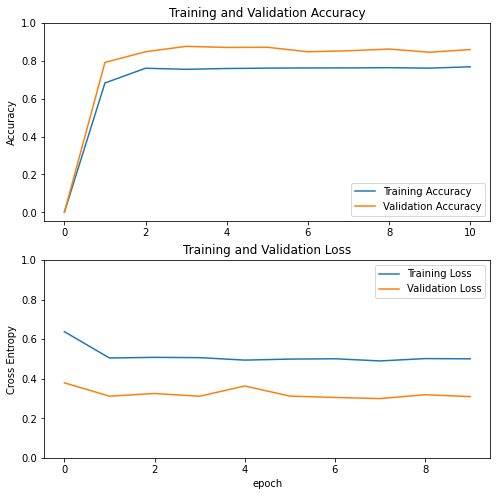

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model2)

# _, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, "/content/SavedModel", include_optimizer=False)

In [ ]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [ ]:
def representative_dataset():
  for data in tf.data.Dataset.from_tensor_slices((images)).batch(1).take(100):
    yield [tf.dtypes.cast(data, tf.float32)]

In [ ]:
import sys
converter = tf.lite.TFLiteConverter.from_saved_model('/content/SavedModel')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

_, quantized_tflite_file = tempfile.mkstemp('.tflite')

with open("/content/model.tflite", 'wb') as f:
  f.write(tflite_quant_model)
print('Saved quantized and pruned TFLite model to:', quantized_tflite_file)
print("Size of tflite model ",sys.getsizeof(tflite_quant_model))

Saved quantized and pruned TFLite model to: /tmp/tmp5vdcoq55.tflite
Size of tflite model  2647833


In [ ]:

!apt-get update && apt-get -qq install xxd
!xxd -i "/content/model.tflite" > model_data.cc

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 252 kB in 2s (146 kB/s)
Reading package lis

In [ ]:
os.path.getsize('/content/model_data.cc')

16328194

In [ ]:
loss, accuracy = model2.evaluate(test_dataset)

38/38 [==============================] - 3s 60ms/step - loss: 0.3097 - accuracy: 0.8595
